In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset
df = pd.read_csv('../../../../Data/Creation/CSV/Combined_Log_Excl_Roil_Clean.csv')

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Rename columns to meet Prophet's requirements
# Prophet requires the columns to be named 'ds' for the datestamp and 'y' for the metric to forecast
prophet_df = df.rename(columns={'date': 'ds', 'Real Oil Prices': 'y'})

# Display the first few rows of the DataFrame
prophet_df.head()

,ds,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,y
0,1992-02-01,8.985233,8.838189,4.022992,13.540263,12.008920,4.126003,4.254484,4.229009,4.385748,...,4.063009,2.475698,2.615204,2.424803,4.231204,11.067669,12.153474,6.612267,2.836180,13.715729
1,1992-03-01,8.986886,8.839001,4.024816,13.544280,12.005919,4.134350,4.262926,4.237888,4.394678,...,4.065979,2.478218,2.621766,2.426571,4.330733,11.050763,12.159442,6.619469,2.786412,13.601725
2,1992-04-01,8.990617,8.841752,4.025655,13.550922,12.011936,4.142042,4.270416,4.245491,4.404083,...,4.069727,2.481568,2.622492,2.430099,4.346399,11.071004,12.159567,6.628021,2.784301,14.512195
3,1992-05-01,8.995945,8.847245,4.030801,13.542184,12.017403,4.145290,4.275880,4.251300,4.410553,...,4.070922,2.482404,2.622492,2.432736,4.371976,11.038303,12.159899,6.640681,2.689751,15.017895
4,1992-06-01,9.000118,8.851692,4.033497,13.552670,12.020207,4.145887,4.273481,4.248251,4.405713,...,4.072355,2.485740,2.630449,2.434490,4.387014,11.051223,12.169043,6.652466,2.691453,15.981442


## Model Training and Forecasting

08:49:53 - cmdstanpy - INFO - Chain [1] start processing
08:49:53 - cmdstanpy - INFO - Chain [1] done processing


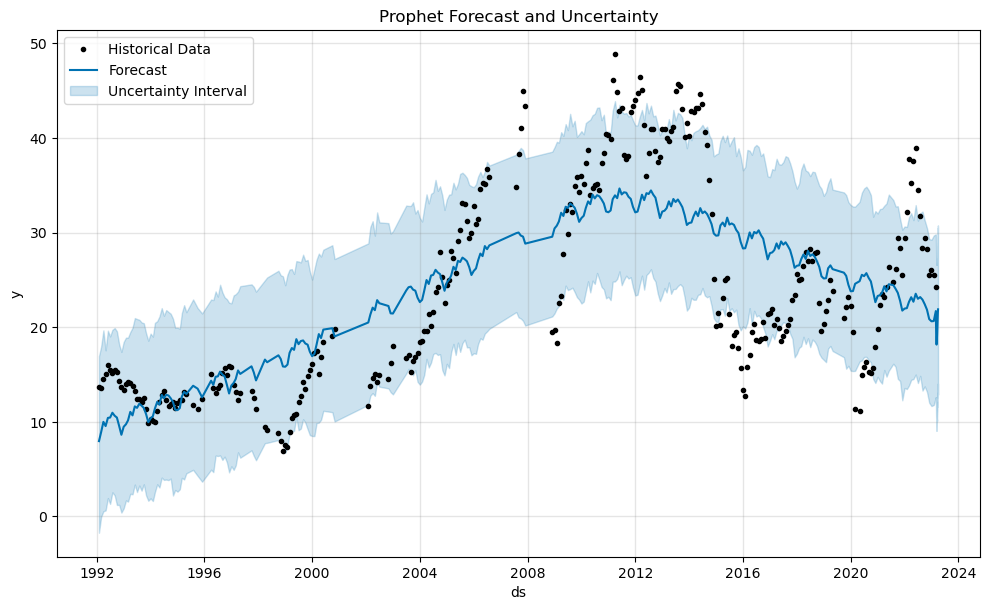

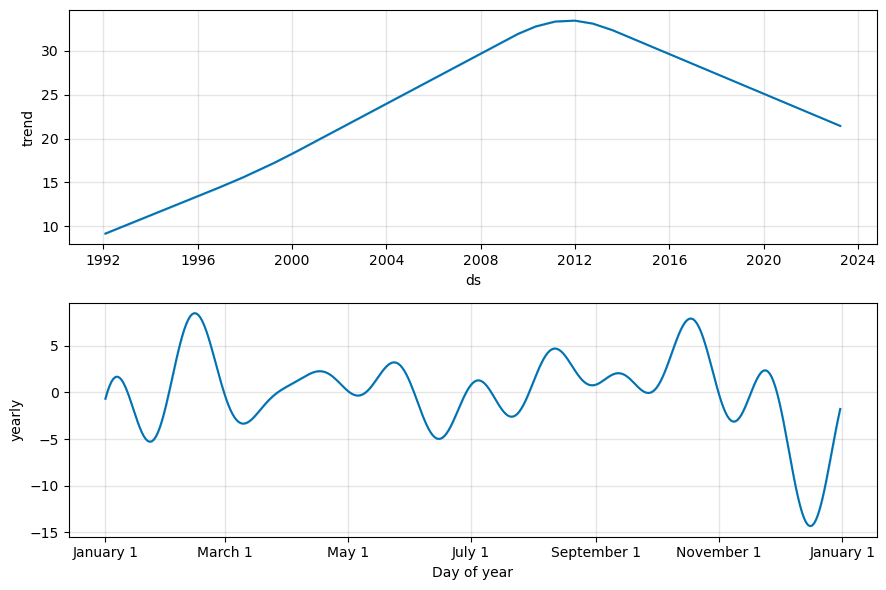

In [9]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future = model.make_future_dataframe(periods=30)

# Generate forecasts
forecast = model.predict(future)

# Plot the historical data and forecasts
fig1 = model.plot(forecast)
plt.legend(labels=['Historical Data', 'Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Prophet Forecast and Uncertainty')
plt.show()

# Plot the components of the forecast (trend, weekly, yearly)
fig2 = model.plot_components(forecast)
plt.show()

- Actual: This represents the actual data points from the dataset.
- Forecast: This is the forecasted values generated by the Prophet model for the future dates.
- Uncertainty Interval: This is the confidence interval around the forecasts, indicating the range within which the actual values are likely to fall with a certain level of confidence.

#### Parameter Tuning - `changepoint_prior_scale` which controls how sensitive the model is to potential changepoints where the trend changes.
- Higher values will make the trend more flexible, lower values will make the trend less flexible.

### Calculate Performance Metrics

In [10]:
# Calculate forecast error metrics using the historical data
y_true = prophet_df['y']
y_pred = forecast.loc[:len(y_true)-1, 'yhat']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 5.57
Mean Squared Error (MSE): 47.39
Root Mean Squared Error (RMSE): 6.88
R^2 Score: 0.59
Mean Absolute Percentage Error (MAPE): 26.51%


### Parameter Tuning for Changepoint Sensitivity

08:49:54 - cmdstanpy - INFO - Chain [1] start processing
08:49:54 - cmdstanpy - INFO - Chain [1] done processing


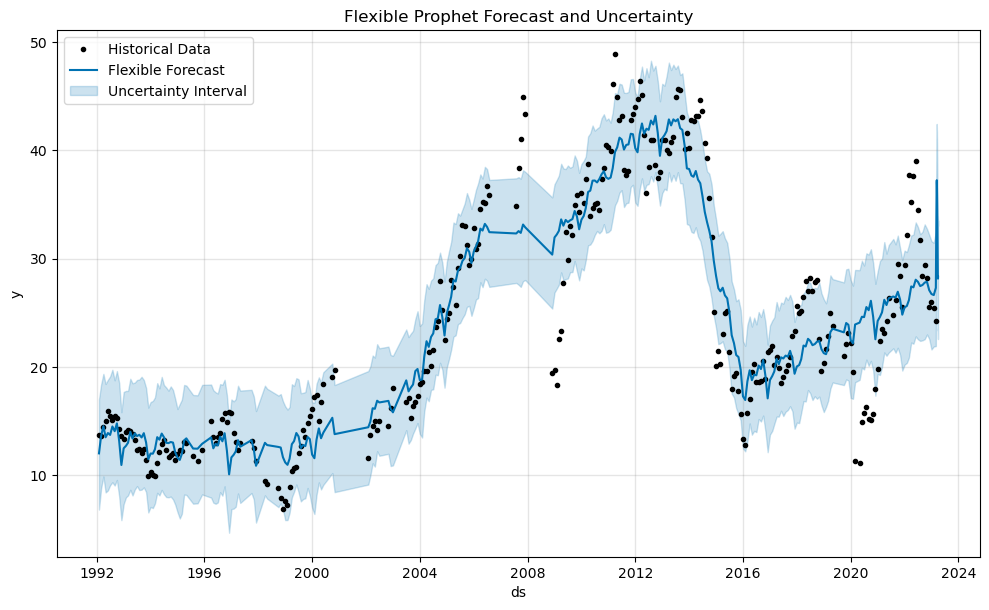

In [11]:
# Tune the changepoint_prior_scale for more flexible trend
flexible_model = Prophet(changepoint_prior_scale=0.5)
flexible_model.fit(prophet_df)

# Create a DataFrame with future dates for forecasting (30 days into the future)
future_flexible = flexible_model.make_future_dataframe(periods=30)

# Generate forecasts with the flexible model
forecast_flexible = flexible_model.predict(future_flexible)

# Plot the historical data and the flexible forecasts
fig3 = flexible_model.plot(forecast_flexible)
plt.legend(labels=['Historical Data', 'Flexible Forecast', 'Uncertainty Interval'], loc='upper left')
plt.title('Flexible Prophet Forecast and Uncertainty')
plt.show()

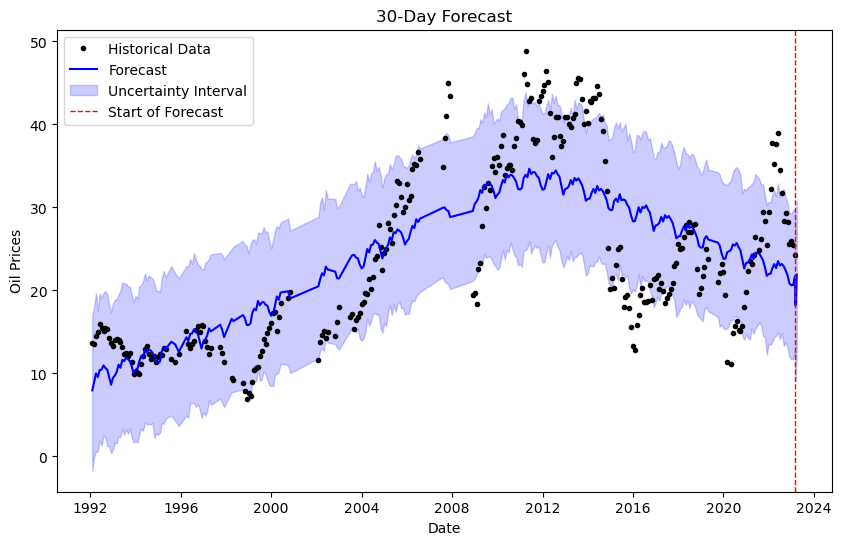

In [12]:
# Plot the forecast for the future 30-day period
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the historical data
ax.plot(prophet_df['ds'], prophet_df['y'], 'k.', label='Historical Data')
# Plot the predicted means as a blue line for the entire forecast period
ax.plot(forecast['ds'], forecast['yhat'], ls='-', color='blue', label='Forecast')
# Plot the prediction intervals as a shaded area for the entire forecast period
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight the 30-day prediction period with a vertical line
ax.axvline(x=prophet_df['ds'].iloc[-1], color='red', linestyle='--', lw=1, label='Start of Forecast')

# Set labels and titles
ax.set_xlabel('Date')
ax.set_ylabel('Oil Prices')
ax.set_title('30-Day Forecast')
ax.legend()

plt.show()

In [13]:
# Check the last date of historical data
last_historical_date = prophet_df['ds'].iloc[-1]
print(f"Last historical date: {last_historical_date}")

# Check the first date of forecast beyond historical data
first_forecasted_date = forecast.loc[len(prophet_df):, 'ds'].iloc[0]
print(f"First forecasted date: {first_forecasted_date}")


Last historical date: 2023-03-01 00:00:00
First forecasted date: 2023-03-02 00:00:00


In [14]:
# Check the future dates in forecast dataframe
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds       yhat  yhat_lower  yhat_upper
328 2023-03-27  21.322951   12.771880   29.892997
329 2023-03-28  21.481027   12.557656   29.939129
330 2023-03-29  21.626441   14.063286   30.758418
331 2023-03-30  21.761287   13.016084   30.557610
332 2023-03-31  21.887899   12.867843   30.539222
